# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                      
Sample_141  A0A0A0MRZ8;P04433                                                      23.182
Sample_093  A0A0U1RR20;Q92954;Q92954-2;Q92954-3;Q92954-4;Q92954-5;Q92954-6         17.909
Sample_164  P04264                                                                 17.650
Sample_042  Q9UP79                                                                 14.729
Sample_140  A0A087WTY6;A3KFI1;A3KFI2;A3KFI3;A3KFI4;A3KFI5;E5RFZ1;P41271;P41271-2   21.571
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                             
Sample_085  Q9P1W8;Q9P1W8-2;Q9P1W8-4                      16.089
Sample_152  Q96FE7-4                                      18.737
Sample_030  E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2   13.942
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.161
            A0A075B6Q5                 13.205
            A0A075B6R2                 12.032
            A0A075B6S5                 14.004
            A0A087WSY4                 12.606
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.961
            Q9UI40;Q9UI40-2            12.558
            Q9UIW2                     15.054
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.184
            Q9UP79                     12.548
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.631,15.050,16.842,19.863,15.937,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.791,19.067,...,15.528,15.576,13.718,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.902,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.233,17.705,17.039,15.802,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.101,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.308,15.345,17.084,18.708,14.249,19.433,12.304,10.317
Sample_207,15.739,16.877,15.469,16.898,13.267,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.382,11.593,13.756,12.599,11.802,11.598,12.712,13.964,12.386,13.240
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.289,19.067,16.127,...,14.428,13.107,12.230,12.333,13.617,12.949,11.943,13.357,13.253,11.832
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.956,12.895,12.912,13.132,12.856,13.450,12.630,12.719,14.869,11.738
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.307,13.082,13.012,12.300,13.171,13.055,13.291,12.830,12.430,14.844
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.586,13.325,13.213,12.103,13.745,14.669,13.191,12.590,13.771,13.987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.171,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 309.79it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.50it/s]

100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.50it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.06it/s]

100%|██████████| 4/4 [00:00<00:00,  3.67it/s]

100%|██████████| 4/4 [00:00<00:00,  4.17it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.36it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.15it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.42it/s]

100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.73it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.90it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.92it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.48it/s]

100%|██████████| 6/6 [00:01<00:00,  3.87it/s]

100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.05it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.56it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.16it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.46it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.28it/s]

100%|██████████| 7/7 [00:02<00:00,  2.90it/s]

100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.66it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.36it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.11it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.98it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.09it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.89it/s]

100%|██████████| 8/8 [00:02<00:00,  2.86it/s]

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  9.45it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.61it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.33it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.95it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.84it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.03it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.53it/s]

100%|██████████| 9/9 [00:02<00:00,  3.21it/s]

100%|██████████| 9/9 [00:02<00:00,  4.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.22it/s]

 30%|███       | 3/10 [00:00<00:01,  5.55it/s]

 40%|████      | 4/10 [00:00<00:01,  4.51it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.07it/s]

 60%|██████    | 6/10 [00:01<00:00,  5.57it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.96it/s]

 80%|████████  | 8/10 [00:01<00:00,  6.22it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.45it/s]

100%|██████████| 10/10 [00:01<00:00,  6.36it/s]

100%|██████████| 10/10 [00:01<00:00,  5.90it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.44it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.02it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.21it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.23it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.28it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.36it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.27it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.36it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.45it/s]

100%|██████████| 11/11 [00:02<00:00,  4.66it/s]

100%|██████████| 11/11 [00:02<00:00,  4.62it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.52it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.48it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.38it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.79it/s]

 50%|█████     | 6/12 [00:01<00:01,  5.07it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  5.37it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.09it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.91it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  4.72it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.55it/s]

100%|██████████| 12/12 [00:02<00:00,  4.59it/s]

100%|██████████| 12/12 [00:02<00:00,  4.99it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.14it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.40it/s]

 31%|███       | 4/13 [00:00<00:01,  4.98it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.67it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.61it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.64it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.83it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.97it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.87it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.58it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.58it/s]

100%|██████████| 13/13 [00:02<00:00,  4.57it/s]

100%|██████████| 13/13 [00:02<00:00,  4.77it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.97it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.21it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.84it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.31it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.15it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.31it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.30it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.37it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.36it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.30it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.49it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.39it/s]

100%|██████████| 14/14 [00:03<00:00,  4.48it/s]

100%|██████████| 14/14 [00:03<00:00,  4.50it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.72it/s]

 20%|██        | 3/15 [00:00<00:02,  5.27it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.80it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.27it/s]

 40%|████      | 6/15 [00:01<00:02,  4.33it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.43it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.45it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.49it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.44it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.44it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.45it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.36it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.28it/s]

100%|██████████| 15/15 [00:03<00:00,  3.85it/s]

100%|██████████| 15/15 [00:03<00:00,  4.38it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.047 0.018          0.723 0.383       0.103   
2             0.006 0.007      0.055 0.024          0.619 0.135       0.461   
3             0.003 0.000      0.042 0.015          0.814 0.087       0.717   
4             0.004 0.003      0.043 0.016          0.809 0.084       0.766   
5             0.005 0.004      0.054 0.020          0.834 0.084       0.786   
6             0.005 0.005      0.052 0.017          0.837 0.087       0.784   
7             0.007 0.007      0.061 0.024          0.830 0.091       0.776   
8             0.007 0.007      0.072 0.031          0.822 0.083       0.834   
9             0.004 0.003      0.045 0.018          0.824 0.085       0.830   
10            0.002 0.000      0.022 0.005          0.815 0.082       0.824   
11            0.003 0.000      0.035 0.010          0.825 0.078       0.826   
12            0.003 0.000      0.034 0.009          0.826 0.077       0.822   
13            0.004 0.000      0.036 0.005          0.829 0.084       0.796   
14            0.004 0.003      0.039 0.009          0.828 0.082       0.792   
15            0.004 0.002      0.035 0.004          0.826 0.083       0.785   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.173 0.128                  0.544 0.040        0.859   
2          0.118   0.517 0.098                  0.621 0.066        0.701   
3          0.103   0.758 0.077                  0.798 0.061        0.903   
4          0.106   0.782 0.072                  0.815 0.059        0.908   
5          0.102   0.805 0.070                  0.834 0.058        0.915   
6          0.103   0.804 0.070                  0.834 0.059        0.913   
7          0.111   0.796 0.074                  0.827 0.061        0.912   
8          0.103   0.824 0.072                  0.850 0.061        0.923   
9          0.107   0.822 0.074                  0.849 0.063        0.920   
10         0.109   0.815 0.071                  0.842 0.060        0.919   
11         0.105   0.822 0.070                  0.848 0.060        0.920   
12         0.108   0.819 0.069                  0.846 0.059        0.920   
13         0.106   0.807 0.074                  0.837 0.061        0.921   
14         0.102   0.804 0.070                  0.834 0.057        0.919   
15         0.098   0.800 0.067                  0.830 0.055        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.828 0.089        210.000 0.000  
2          0.082                  0.648 0.098        210.000 0.000  
3          0.049                  0.880 0.062        210.000 0.000  
4          0.048                  0.885 0.057        210.000 0.000  
5          0.050                  0.896 0.061        210.000 0.000  
6          0.051                  0.895 0.061        210.000 0.000  
7          0.054                  0.894 0.063        210.000 0.000  
8          0.046                  0.912 0.050        210.000 0.000  
9          0.049                  0.907 0.054        210.000 0.000  
10         0.048                  0.908 0.049        210.000 0.000  
11         0.047                  0.911 0.049        210.000 0.000  
12         0.047                  0.910 0.049        210.000 0.000  
13         0.049                  0.913 0.049        210.000 0.000  
14         0.048                  0.911 0.049        210.000 0.000  
15         0.047                  0.910 0.048 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 481.05it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.28it/s]

100%|██████████| 2/2 [00:00<00:00,  7.23it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.89it/s]

100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.30it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.19it/s]

100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.12it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.57it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.01it/s]

100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

100%|██████████| 5/5 [00:01<00:00,  4.05it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.83it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.27it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

100%|██████████| 6/6 [00:01<00:00,  3.56it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.39it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.10it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.38it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.84it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.61it/s]

100%|██████████| 7/7 [00:01<00:00,  4.64it/s]

100%|██████████| 7/7 [00:01<00:00,  5.02it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.53it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.47it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.93it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.31it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.97it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.95it/s]

100%|██████████| 8/8 [00:01<00:00,  3.91it/s]

100%|██████████| 8/8 [00:01<00:00,  4.32it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.59it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.50it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.80it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.45it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.23it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.02it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.96it/s]

100%|██████████| 9/9 [00:02<00:00,  3.99it/s]

100%|██████████| 9/9 [00:02<00:00,  4.36it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.61it/s]

 30%|███       | 3/10 [00:00<00:01,  4.40it/s]

 40%|████      | 4/10 [00:01<00:01,  3.21it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.09it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.93it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.00it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.94it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.84it/s]

100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.74it/s]

 27%|██▋       | 3/11 [00:01<00:02,  2.83it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.47it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.29it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.44it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.78it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.98it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  3.11it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.27it/s]

100%|██████████| 11/11 [00:03<00:00,  3.34it/s]

100%|██████████| 11/11 [00:03<00:00,  2.94it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.26it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.44it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.53it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.39it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.03it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.68it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.46it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.37it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.32it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.57it/s]

100%|██████████| 12/12 [00:04<00:00,  2.81it/s]

100%|██████████| 12/12 [00:04<00:00,  2.96it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.39it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.28it/s]

 31%|███       | 4/13 [00:01<00:02,  3.10it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.18it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.10it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.16it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.29it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.46it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.51it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.52it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.67it/s]

100%|██████████| 13/13 [00:03<00:00,  3.79it/s]

100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.64it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.76it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.85it/s]

 36%|███▌      | 5/14 [00:00<00:01,  4.60it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.12it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.52it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.19it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.92it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.70it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.51it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.39it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.35it/s]

100%|██████████| 14/14 [00:04<00:00,  2.40it/s]

100%|██████████| 14/14 [00:04<00:00,  3.01it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.58it/s]

 20%|██        | 3/15 [00:00<00:03,  3.27it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.86it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.72it/s]

 40%|████      | 6/15 [00:02<00:03,  2.81it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.83it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.90it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.07it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.17it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.24it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.14it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.30it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.37it/s]

100%|██████████| 15/15 [00:04<00:00,  3.49it/s]

100%|██████████| 15/15 [00:04<00:00,  3.18it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.035 0.002          0.238 0.385       0.029   
2             0.003 0.000      0.036 0.006          0.807 0.101       0.718   
3             0.003 0.000      0.037 0.008          0.828 0.090       0.734   
4             0.004 0.002      0.036 0.008          0.811 0.089       0.743   
5             0.004 0.002      0.043 0.015          0.814 0.086       0.751   
6             0.003 0.000      0.035 0.001          0.812 0.093       0.743   
7             0.003 0.001      0.027 0.006          0.809 0.095       0.742   
8             0.003 0.001      0.030 0.005          0.814 0.095       0.762   
9             0.006 0.006      0.056 0.020          0.807 0.090       0.781   
10            0.006 0.005      0.057 0.030          0.804 0.081       0.808   
11            0.007 0.007      0.061 0.028          0.809 0.085       0.802   
12            0.004 0.000      0.037 0.008          0.806 0.091       0.800   
13            0.006 0.005      0.062 0.021          0.807 0.090       0.798   
14            0.005 0.004      0.042 0.015          0.812 0.085       0.796   
15            0.005 0.004      0.046 0.016          0.818 0.081       0.794   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.053   0.050 0.088                  0.509 0.023        0.875   
2          0.118   0.754 0.089                  0.794 0.070        0.881   
3          0.130   0.772 0.093                  0.810 0.070        0.878   
4          0.122   0.770 0.084                  0.807 0.067        0.882   
5          0.119   0.775 0.080                  0.811 0.064        0.879   
6          0.119   0.770 0.085                  0.807 0.067        0.880   
7          0.120   0.769 0.087                  0.806 0.069        0.878   
8          0.113   0.781 0.077                  0.814 0.063        0.878   
9          0.114   0.789 0.082                  0.821 0.068        0.904   
10         0.114   0.802 0.079                  0.831 0.066        0.916   
11         0.105   0.801 0.074                  0.830 0.062        0.917   
12         0.107   0.799 0.078                  0.828 0.066        0.916   
13         0.106   0.798 0.076                  0.827 0.065        0.915   
14         0.103   0.800 0.074                  0.829 0.062        0.915   
15         0.100   0.801 0.071                  0.831 0.060        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.840 0.087        210.000 0.000  
2          0.055                  0.849 0.077        210.000 0.000  
3          0.056                  0.854 0.070        210.000 0.000  
4          0.055                  0.859 0.068        210.000 0.000  
5          0.056                  0.857 0.068        210.000 0.000  
6          0.054                  0.858 0.068        210.000 0.000  
7          0.055                  0.856 0.069        210.000 0.000  
8          0.058                  0.858 0.073        210.000 0.000  
9          0.052                  0.885 0.062        210.000 0.000  
10         0.049                  0.901 0.059        210.000 0.000  
11         0.049                  0.903 0.057        210.000 0.000  
12         0.049                  0.901 0.057        210.000 0.000  
13         0.049                  0.901 0.056        210.000 0.000  
14         0.048                  0.902 0.056        210.000 0.000  
15         0.042                  0.905 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1092.84it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 33.43it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 30.77it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 23.27it/s]

100%|██████████| 4/4 [00:00<00:00, 21.21it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.04it/s]

100%|██████████| 5/5 [00:00<00:00, 16.82it/s]

100%|██████████| 5/5 [00:00<00:00, 16.98it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.57it/s]

100%|██████████| 6/6 [00:00<00:00, 15.38it/s]

100%|██████████| 6/6 [00:00<00:00, 15.89it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 25.68it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 17.24it/s]

100%|██████████| 7/7 [00:00<00:00, 17.07it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 24.78it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 18.96it/s]

100%|██████████| 8/8 [00:00<00:00, 16.06it/s]

100%|██████████| 8/8 [00:00<00:00, 16.98it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 26.26it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 17.41it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 14.38it/s]

100%|██████████| 9/9 [00:00<00:00, 15.38it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.61it/s]

 60%|██████    | 6/10 [00:00<00:00, 15.77it/s]

 80%|████████  | 8/10 [00:00<00:00, 14.89it/s]

100%|██████████| 10/10 [00:00<00:00, 14.39it/s]

100%|██████████| 10/10 [00:00<00:00, 15.11it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.78it/s]

 45%|████▌     | 5/11 [00:00<00:00, 14.10it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.82it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 11.58it/s]

100%|██████████| 11/11 [00:00<00:00, 12.58it/s]

100%|██████████| 11/11 [00:00<00:00, 12.81it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.66it/s]

 50%|█████     | 6/12 [00:00<00:00, 15.21it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.56it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.20it/s]

100%|██████████| 12/12 [00:00<00:00, 14.80it/s]

100%|██████████| 12/12 [00:00<00:00, 15.04it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 22.75it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.15it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.56it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 13.07it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 11.59it/s]

100%|██████████| 13/13 [00:01<00:00, 12.70it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.77it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.77it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.51it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 15.55it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 14.25it/s]

100%|██████████| 14/14 [00:00<00:00, 13.25it/s]

100%|██████████| 14/14 [00:00<00:00, 14.73it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 26.37it/s]

 40%|████      | 6/15 [00:00<00:00, 18.07it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.57it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.90it/s]

 80%|████████  | 12/15 [00:00<00:00, 16.59it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.64it/s]

100%|██████████| 15/15 [00:00<00:00, 16.02it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.045 0.015          0.000 0.000       0.000   
2             0.004 0.003      0.040 0.014          0.642 0.114       0.420   
3             0.005 0.004      0.052 0.023          0.627 0.122       0.429   
4             0.004 0.004      0.045 0.017          0.613 0.109       0.421   
5             0.005 0.005      0.053 0.026          0.669 0.094       0.597   
6             0.005 0.006      0.052 0.020          0.649 0.088       0.575   
7             0.005 0.004      0.051 0.024          0.708 0.074       0.677   
8             0.004 0.003      0.045 0.016          0.690 0.078       0.675   
9             0.005 0.004      0.055 0.024          0.680 0.079       0.670   
10            0.005 0.003      0.057 0.019          0.682 0.083       0.664   
11            0.006 0.004      0.053 0.024          0.678 0.083       0.658   
12            0.005 0.004      0.050 0.018          0.684 0.077       0.657   
13            0.006 0.007      0.049 0.021          0.688 0.077       0.666   
14            0.005 0.004      0.058 0.029          0.682 0.077       0.658   
15            0.007 0.006      0.060 0.030          0.699 0.078       0.666   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.749   
2          0.090   0.501 0.085                  0.621 0.058        0.655   
3          0.099   0.503 0.094                  0.618 0.066        0.665   
4          0.103   0.493 0.094                  0.612 0.063        0.657   
5          0.103   0.626 0.083                  0.689 0.067        0.768   
6          0.106   0.605 0.084                  0.673 0.064        0.766   
7          0.113   0.686 0.077                  0.735 0.057        0.816   
8          0.108   0.677 0.076                  0.726 0.060        0.821   
9          0.112   0.670 0.079                  0.719 0.064        0.816   
10         0.115   0.668 0.084                  0.718 0.067        0.814   
11         0.108   0.664 0.081                  0.714 0.066        0.811   
12         0.111   0.664 0.075                  0.716 0.058        0.809   
13         0.113   0.671 0.078                  0.722 0.060        0.812   
14         0.110   0.665 0.076                  0.716 0.058        0.807   
15         0.104   0.677 0.072                  0.727 0.056        0.811   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.689 0.086        210.000 0.000  
2          0.071                  0.622 0.074        210.000 0.000  
3          0.068                  0.622 0.079        210.000 0.000  
4          0.070                  0.610 0.079        210.000 0.000  
5          0.061                  0.674 0.074        210.000 0.000  
6          0.061                  0.682 0.073        210.000 0.000  
7          0.054                  0.755 0.065        210.000 0.000  
8          0.056                  0.756 0.071        210.000 0.000  
9          0.056                  0.749 0.071        210.000 0.000  
10         0.056                  0.748 0.070        210.000 0.000  
11         0.055                  0.741 0.071        210.000 0.000  
12         0.053                  0.740 0.071        210.000 0.000  
13         0.054                  0.740 0.074        210.000 0.000  
14         0.053                  0.731 0.073        210.000 0.000  
15         0.057                  0.732 0.076 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,11,15
score_time,8,13,15
test_precision,6,3,7
test_recall,8,10,7
test_f1,8,10,7
test_balanced_accuracy,8,10,7
test_roc_auc,8,15,8
test_average_precision,13,15,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.04it/s]

 20%|██        | 3/15 [00:01<00:04,  2.81it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.64it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.71it/s]

 40%|████      | 6/15 [00:02<00:03,  2.80it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.92it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.10it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.32it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.49it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.62it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.63it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.68it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.77it/s]

100%|██████████| 15/15 [00:04<00:00,  3.81it/s]

100%|██████████| 15/15 [00:04<00:00,  3.33it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.87it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.53it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.15it/s]

100%|██████████| 8/8 [00:00<00:00, 13.43it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.85it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.85it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.24it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.82it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.87it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.04it/s]

100%|██████████| 8/8 [00:01<00:00,  4.20it/s]

100%|██████████| 8/8 [00:01<00:00,  4.24it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


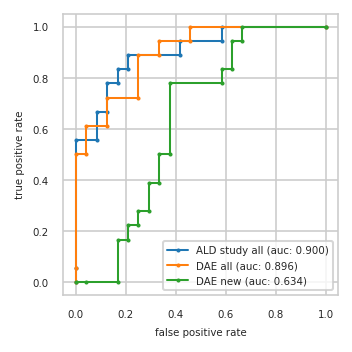

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.556   0.000 0.500   0.167 0.000
3          0.083 0.556   0.042 0.500   0.167 0.167
4          0.083 0.667   0.042 0.611   0.208 0.167
5          0.125 0.667   0.125 0.611   0.208 0.222
6          0.125 0.778   0.125 0.722   0.250 0.222
7          0.167 0.778   0.250 0.722   0.250 0.278
8          0.167 0.833   0.250 0.889   0.292 0.278
9          0.208 0.833   0.333 0.889   0.292 0.389
10         0.208 0.889   0.333 0.944   0.333 0.389
11         0.417 0.889   0.458 0.944   0.333 0.500
12         0.417 0.944   0.458 1.000   0.375 0.500
13         0.583 0.944   1.000 1.000   0.375 0.778
14         0.583 1.000     NaN   NaN   0.583 0.778
15         1.000 1.000     NaN   NaN   0.583 0.833
16           NaN   NaN     NaN   NaN   0.625 0.833
17           NaN   NaN     NaN   NaN   0.625 0.944
18           NaN   NaN     NaN   NaN   0.667 0.944
19           NaN   NaN     NaN   NaN   0.667 1.000
20           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P31946;P31946-2,P22676,A0A0J9YW36;Q9NZ72;Q9NZ72-2
2,Q9BRA2,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,Q96GD0
3,Q9UM22,P04075,P51688
4,P61981,P61981,P31321
5,C9JF17;P05090,Q9Y2T3;Q9Y2T3-3,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
6,P04075,P14174,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,P14174,Q14894,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
8,None,P63104,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


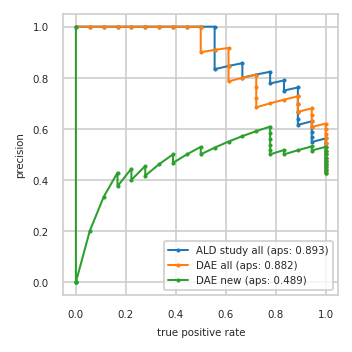

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.621 1.000     0.517 0.833
14         0.607 0.944     0.607 0.944     0.500 0.778
15         0.630 0.944     0.630 0.944     0.519 0.778
16         0.615 0.889     0.654 0.944     0.538 0.778
17         0.640 0.889     0.680 0.944     0.560 0.778
18         0.667 0.889     0.667 0.889     0.583 0.778
19         0.696 0.889     0.696 0.889     0.609 0.778
20         0.727 0.889     0.727 0.889     0.591 0.722
21         0.762 0.889     0.714 0.833     0.571 0.667
22         0.750 0.833     0.700 0.778     0.550 0.611
23         0.789 0.833     0.684 0.722     0.526 0.556
24         0.778 0.778     0.722 0.722     0.500 0.500
25         0.824 0.778     0.765 0.722     0.529 0.500
26         0.812 0.722     0.812 0.722     0.500 0.444
27         0.800 0.667     0.800 0.667     0.467 0.389
28         0.857 0.667     0.786 0.611     0.500 0.389
29         0.846 0.611     0.846 0.611     0.462 0.333
30         0.833 0.556     0.917 0.611     0.417 0.278
31         0.909 0.556     0.909 0.556     0.455 0.278
32         1.000 0.556     0.900 0.500     0.400 0.222
33         1.000 0.500     1.000 0.500     0.444 0.222
34         1.000 0.444     1.000 0.444     0.375 0.167
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.333 0.111
37         1.000 0.278     1.000 0.278     0.200 0.056
38         1.000 0.222     1.000 0.222     0.000 0.000
39         1.000 0.167     1.000 0.167     0.000 0.000
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


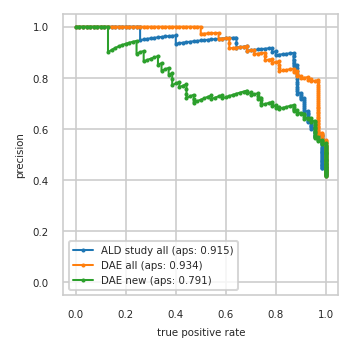

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


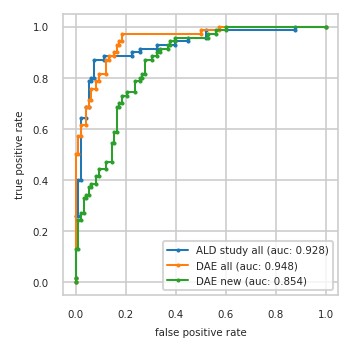

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}